# Domača naloga 2

In [4]:
using Revise
using Domaca02
using Plots

## Porazdelitvena funkcija normalne slučajne spremenljivke

Da lahko izračunamo porazdelitvene funkcije za standardno normalno porazdeljeno slučajno spremenljivko $X \sim N(0,1)$, jo moramo najprej preurediti.
Funkcija, poimenovana $\Phi$, je definirana na naslednji način:

$$
    \Phi(x) = P(X \leq x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} e^{-\frac{t^2}{2}} dt
$$

Opazimo, da se v funkciji nahaja integral brez spodnje meje (meja je $-\infty$), kar ni primerno za numerično integracijo.
Zaradi tega moramo funkcijo preurediti, da bo vsebovala zgolj integrale z končnimi mejami.
Čeprav se to ponavadi naredi z substitucijo $u = \frac{1}{t}$, lahko tukaj izkoristimo lastnost normalne porazdelitve $N(0,1)$, da mora funkcija imeti pri $x = 0$ vrednost $0.5$ in da je ta simetrična.
Sedaj lahko zapišemo bolj primerno obliko funkcije.

$$
    \Phi(x) = 0.5 + \text{sign}(x) \cdot \frac{1}{\sqrt{2\pi}} \int_{0}^{|x|} e^{-\frac{t^2}{2}} dt
$$

Za izračun integrala je bila izbrana Rombergova metoda.
Implementacija uporabi trikotniško lastnost vrednosti $T_m(h/2^l)$ za njihov izračun in se ustavi, ali ko doseže mejo števila iteracij, ali ko se nova izračunana vrednost od prejšnje ne razlikuje za več kot od podane tolerance.
Rombergova metoda nam omogoča dinamično zmanjševanje koraka, kar je primerno za to funkcijo, saj vhodna vrednost $x$ spremeni mejo integrala.

In [5]:
function Φ(x)
    if x == 0
        return 0.5
    end

    p(x) = exp(-x*x/2)
    f    = romberg(p, 0, abs(x), eps()) / sqrt(2pi)
    return 0.5 + (x < 0 ? -f : f)
end

Φ (generic function with 1 method)

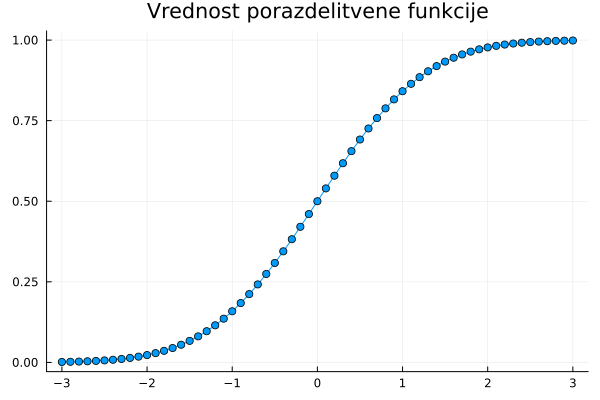

In [6]:
x = -3:0.1:3
y = Φ.(x)
plot(x, y, shape=:circle, label="", title="Vrednost porazdelitvene funkcije")

## Sila težnosti

Za izračun sile težnosti med dvema enotskima homogenima kockama na razdalji 1 nam je podana naslednja funkcija:

$$
F = \int_{T_1} \int_{T_2} \frac{r_1 - r_2}{|| r_1 - r_2 ||^2}\, dr_1\, dr_2
$$

Ker sta območji $T_1$ in $T_2$ v tridimenzionalnem prostoru, je celoten integral 6-dimenzionalen.
Zaradi visoke dimenzionalnosti se najprej odločimo za implementacijo **Monte Carlo** metode.
Ta je primerna, saj izkoristi pričakovano vrednost $E$, ki jo pridobimo s povprečno vrednostjo naključno vzorčenih točk na območju $\Omega = T_1 \times T_2$, da izračuna vrednost integrala $F$.

In [22]:
function Ω()
    a = rand(Float64, 6)
    a[4] += 2
    return a
end

function F_(x)
    diff = x[1:3] - x[4:6]
    return diff / (diff[1]^2 + diff[2]^2 + diff[3]^2)
end

monte_carlo(F_, Ω, 1, 1e7)

3-element Vector{Float64}:
 -0.4770839467721084
 -1.9150199889700784e-5
  4.444138853723799e-5

Kot vidimo smo pri kockah, vzporednih po $x$ osi, pridobili silo $F.x \approx -0.4771$.
Kar opazimo pa je to, da kljub visokem številu vzorčenih točk ($10^7$) smo dobili na $y$ in $z$ osi nezanemarljivo velike sile, ki naj bi bile 0.

To se zgodi zaradi naključnosti točk, saj bi pri bolj enakomerni razporeditvi se simetrične se sile izničile.
Zaradi tega in zaradi trivialnih meja postavljenih zaradi kock, implementiramo tudi večdimenzionalno integracijo z uporabo trapeznega in simpsonovega pravila, katera uporabimo za primerjavo z metodo Monte Carlo.

Da si olajšamo delo, območje standardiziramo na $[0,1]^6$ in na novo definiramo funkcijo $F$, kjer zamaknemo $x$ os pri $T_2$ za 2.

In [102]:
xt, wt = trapez(0, 1, 3)
xs, ws = simpson(0, 1, 3)

function F(x)
    diff = x[1:3] - x[4:6] - [2,0,0]
    r    = diff / (diff[1]^2 + diff[2]^2 + diff[3]^2)
    return r
end

println(d_integral(F, xt, wt, 6))
println(d_integral(F, xs, ws, 6))

[-0.46486010099716585, -4.2012834183813297e-19, -3.835365185167472e-18]
[-0.4783030313822585, -1.57378721599849e-18, -9.06833473330454e-18]


Tu lahko vidimo, da se že pri majhnem številu izračunanih točk $3^6$ sile na $y$ in $z$ osi izničijo in dobimo zanemarljivo velike vrednosti, ki jih lahko zanemarimo kot napake.
Sedaj lahko razliko med temi tremi metodami tudi grafično predstavimo.

In [13]:
using Plots

In [109]:
x = 3:2:15
s = [ simpson(0,1,i) for i in x ]
t = [ trapez(0,1,i) for i in x ]
evals = x .^ 6

function integrate(xw)
    x, w = xw
    return d_integral(F, x, w, 6)
end

function monte(n)
    return monte_carlo(F_, Ω, 1, n)
end

simps = integrate.(s)
traps = integrate.(t)
monts = monte.(evals)

X(v) = v[1]
Y(v) = v[2]
Z(v) = v[3]

3-element Vector{Float64}:
 -0.47707912348582304
 -4.502847575541965e-16
 -1.2724479059194308e-16

Da lahko te metode lažje primerjamo med sabo, uvedemo vrednost `real_val`, ki predstavlja resnično vrednost izračunano z uporabo simpsonovega pravila, saj je ta najvišjega reda izmed teh, in veliko večjim številom izračunov vrednosti funkcije.

Sedaj lahko lažje vidimo katera izmed metod hitreje konvergira, in kako hitro.

In [116]:
real_val = integrate(simpson(0,1,25))

3-element Vector{Float64}:
 -0.4770790764250797
  3.5594796683690144e-16
  1.8949236598489858e-16

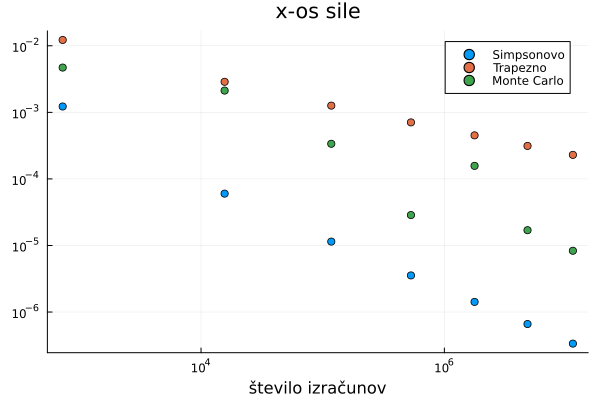

In [117]:

scatter(evals,  abs.(X.(simps) .- X(real_val)), xaxis=:log10, yaxis=:log10, label="Simpsonovo", title="x-os sile", xlabel="število izračunov")
scatter!(evals, abs.(X.(traps) .- X(real_val)), label="Trapezno")
scatter!(evals, abs.(X.(monts) .- X(real_val)), label="Monte Carlo")

Podamo še predstavitev kako se obašajo ničle na $y$ in $z$ oseh skozi različnega števila izračunov

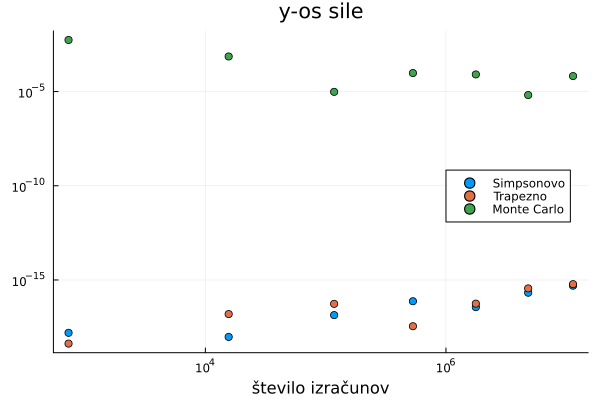

In [120]:
scatter(evals,  abs.(Y.(simps)), xaxis=:log10, yaxis=:log10, label="Simpsonovo", title="y-os sile", leg=:right, xlabel="število izračunov")
scatter!(evals, abs.(Y.(traps)), label="Trapezno")
scatter!(evals, abs.(Y.(monts)), label="Monte Carlo")

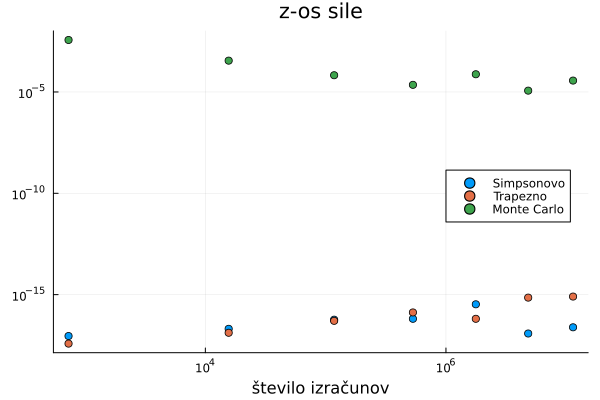

In [121]:
scatter(evals,  abs.(Z.(simps)), xaxis=:log10, yaxis=:log10, label="Simpsonovo", title="z-os sile", leg=:right, xlabel="število izračunov")
scatter!(evals, abs.(Z.(traps)), label="Trapezno")
scatter!(evals, abs.(Z.(monts)), label="Monte Carlo")